# Clasificacion Automatica de Tickets con NLP

### Integrantes
* Alicia Zamorano
* Cesar Quiroga
* Juan Carlos Peralta
* Nilton Apaza

## Descripcion del Problema 

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trabajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling 

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [ ]:
!pip install -q spacy
!pip install -q bertopic
!pip install -q nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 55.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.8 MB/s eta 0:00:00


## Importing the necessary libraries

In [ ]:
import json
import numpy as np
import pandas as pd
import re
import string
import random

# Import NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Import Spacy libraries
import spacy
spacy.prefer_gpu()
import en_core_web_sm
nlp = en_core_web_sm.load()

# Import BERTopic
from bertopic import BERTopic

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

##import json file
from google.colab import files

#date and datetime
from datetime import date


In [ ]:
# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('brown', quiet=True)

True

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [ ]:
# Subiendo el archivo JSON
from google.colab import files
uploaded = files.upload()

Saving complaints.json to complaints.json


In [ ]:
import json
data = json.loads(uploaded['complaints.json'].decode('utf-8'))

In [ ]:
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Realizando una inspeccion al dataset para verificar los datos
print(df.head())

                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00      

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [ ]:
#imprimiendo los nombres de las columnas
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
# Verificando si exiten valores nulos en las columnas
print(df.isnull().any())

_index                               False
_type                                False
_id                                  False
_score                               False
_source.tags                          True
_source.zip_code                      True
_source.complaint_id                 False
_source.issue                        False
_source.date_received                False
_source.state                         True
_source.consumer_disputed            False
_source.product                      False
_source.company_response             False
_source.company                      False
_source.submitted_via                False
_source.date_sent_to_company         False
_source.company_public_response       True
_source.sub_product                   True
_source.timely                       False
_source.complaint_what_happened      False
_source.sub_issue                     True
_source.consumer_consent_provided     True
dtype: bool


In [ ]:
# imprimiendo la cantidad de nulos por columna
print(df.isnull().sum())

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64


In [ ]:
# Eliminando columnas con valores nulos
df.drop(columns=['_source.tags', '_source.company_public_response', '_source.sub_issue'],inplace = True)

In [ ]:
# imprimiendo la cantidad de nulos por columna
print(df.isnull().sum())

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.consumer_consent_provided     1008
dtype: int64


In [ ]:
#identificando valores unicos en los datos
df.nunique()

_index                                   1
_type                                    1
_id                                  78313
_score                                   1
_source.zip_code                      9442
_source.complaint_id                 78313
_source.issue                          154
_source.date_received                 3444
_source.state                           62
_source.consumer_disputed                3
_source.product                         17
_source.company_response                 8
_source.company                          1
_source.submitted_via                    6
_source.date_sent_to_company          3309
_source.sub_product                     72
_source.timely                           2
_source.complaint_what_happened      20931
_source.consumer_consent_provided        5
dtype: int64

In [ ]:
#Eliminando columnas con valores unicos
df.drop(columns=['_id','_source.complaint_id'], inplace=True)

In [ ]:
# Eliminando valores duplicados
df.drop_duplicates(inplace=True)

In [ ]:
df

,_index,_type,_score,_source.zip_code,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.consumer_consent_provided
0,complaint-public-v2,complaint,0.0,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Consent not provided
1,complaint-public-v2,complaint,0.0,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Consent provided
2,complaint-public-v2,complaint,0.0,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Consent provided
3,complaint-public-v2,complaint,0.0,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,Consent not provided
4,complaint-public-v2,complaint,0.0,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,0.0,08857,Closing an account,2018-12-20T12:00:00-05:00,NJ,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,Checking account,Yes,,Consent not provided
78309,complaint-public-v2,complaint,0.0,934XX,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Consent provided
78310,complaint-public-v2,complaint,0.0,923XX,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Consent provided
78311,complaint-public-v2,complaint,0.0,None,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,N/A,Credit card or prepaid card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Consent provided


In [ ]:
#Renombrando columnas
df.rename(columns={"_index":"index", "_type":"type", "_score":"score","_source.zip_code":"zip_code","_source.issue":"issue", "_source.date_received":"date_received", "_source.state": "state", "_source.consumer_disputed": "consumer_disputed", "_source.product": "product", "_source.company_response": "company_response", "_source.company":"company", "_source.submitted_via": "submitted_via", "_source.date_sent_to_company": "date_sent_to_company", "_source.sub_product": "sub_product", "_source.timely":"timely", "_source.complaint_what_happened": "complaint_what_happened", "_source.consumer_consent_provided": "consumer_conset_provided"}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77712 entries, 0 to 78312
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     77712 non-null  object 
 1   type                      77712 non-null  object 
 2   score                     77712 non-null  float64
 3   zip_code                  71012 non-null  object 
 4   issue                     77712 non-null  object 
 5   date_received             77712 non-null  object 
 6   state                     75758 non-null  object 
 7   consumer_disputed         77712 non-null  object 
 8   product                   77712 non-null  object 
 9   company_response          77712 non-null  object 
 10  company                   77712 non-null  object 
 11  submitted_via             77712 non-null  object 
 12  date_sent_to_company      77712 non-null  object 
 13  sub_product               67245 non-null  object 
 14  timely

In [ ]:
#cambiando el tipo de dato de las fechas
df['date_received'] = pd.to_datetime(df['date_received'])
df['date_sent_to_company'] = pd.to_datetime(df['date_sent_to_company'])

In [ ]:
# cambiando el tipo de dato en columnas objects a category
dtypes_dict = {'index':'category','type':'category', 'zip_code':'category', 'state':'category', 'consumer_disputed':'category', 'company':'category', 'submitted_via':'category', 'product':'category', 'sub_product':'category', 'timely':'category', 'consumer_conset_provided':'category'}
df = df.astype(dtypes_dict)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score,77712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cols=['type', 'state', 'company', 'product', 'sub_product','submitted_via']

def get_categories(df, colums):
  for col in colums:
    print(dict(enumerate(df[col].cat.categories)))
    
get_categories(df,cols)

{0: 'complaint'}
{0: 'AA', 1: 'AE', 2: 'AK', 3: 'AL', 4: 'AP', 5: 'AR', 6: 'AS', 7: 'AZ', 8: 'CA', 9: 'CO', 10: 'CT', 11: 'DC', 12: 'DE', 13: 'FL', 14: 'FM', 15: 'GA', 16: 'GU', 17: 'HI', 18: 'IA', 19: 'ID', 20: 'IL', 21: 'IN', 22: 'KS', 23: 'KY', 24: 'LA', 25: 'MA', 26: 'MD', 27: 'ME', 28: 'MH', 29: 'MI', 30: 'MN', 31: 'MO', 32: 'MS', 33: 'MT', 34: 'NC', 35: 'ND', 36: 'NE', 37: 'NH', 38: 'NJ', 39: 'NM', 40: 'NV', 41: 'NY', 42: 'OH', 43: 'OK', 44: 'OR', 45: 'PA', 46: 'PR', 47: 'PW', 48: 'RI', 49: 'SC', 50: 'SD', 51: 'TN', 52: 'TX', 53: 'UNITED STATES MINOR OUTLYING ISLANDS', 54: 'UT', 55: 'VA', 56: 'VI', 57: 'VT', 58: 'WA', 59: 'WI', 60: 'WV', 61: 'WY'}
{0: 'JPMORGAN CHASE & CO.'}
{0: 'Bank account or service', 1: 'Checking or savings account', 2: 'Consumer Loan', 3: 'Credit card', 4: 'Credit card or prepaid card', 5: 'Credit reporting', 6: 'Credit reporting, credit repair services, or other personal consumer reports', 7: 'Debt collection', 8: 'Money transfer, virtual currency, or mone

In [ ]:
def counting_number_of_values_per_cat(df, colums):
   for col in colums:
    print("Number Of Values per Category: "+col) 
    print(df[col].value_counts())

counting_number_of_values_per_cat(df, cols)

Number Of Values per Category: type
complaint    77712
Name: type, dtype: int64
Number Of Values per Category: state
CA                                      13909
NY                                       8700
FL                                       6776
TX                                       5824
IL                                       4104
                                        ...  
UNITED STATES MINOR OUTLYING ISLANDS        3
MH                                          3
AA                                          3
PW                                          1
AS                                          1
Name: state, Length: 62, dtype: int64
Number Of Values per Category: company
JPMORGAN CHASE & CO.    77712
Name: company, dtype: int64
Number Of Values per Category: product
Mortgage                                                                        22636
Checking or savings account                                                     12072
Credit card or prepaid card    

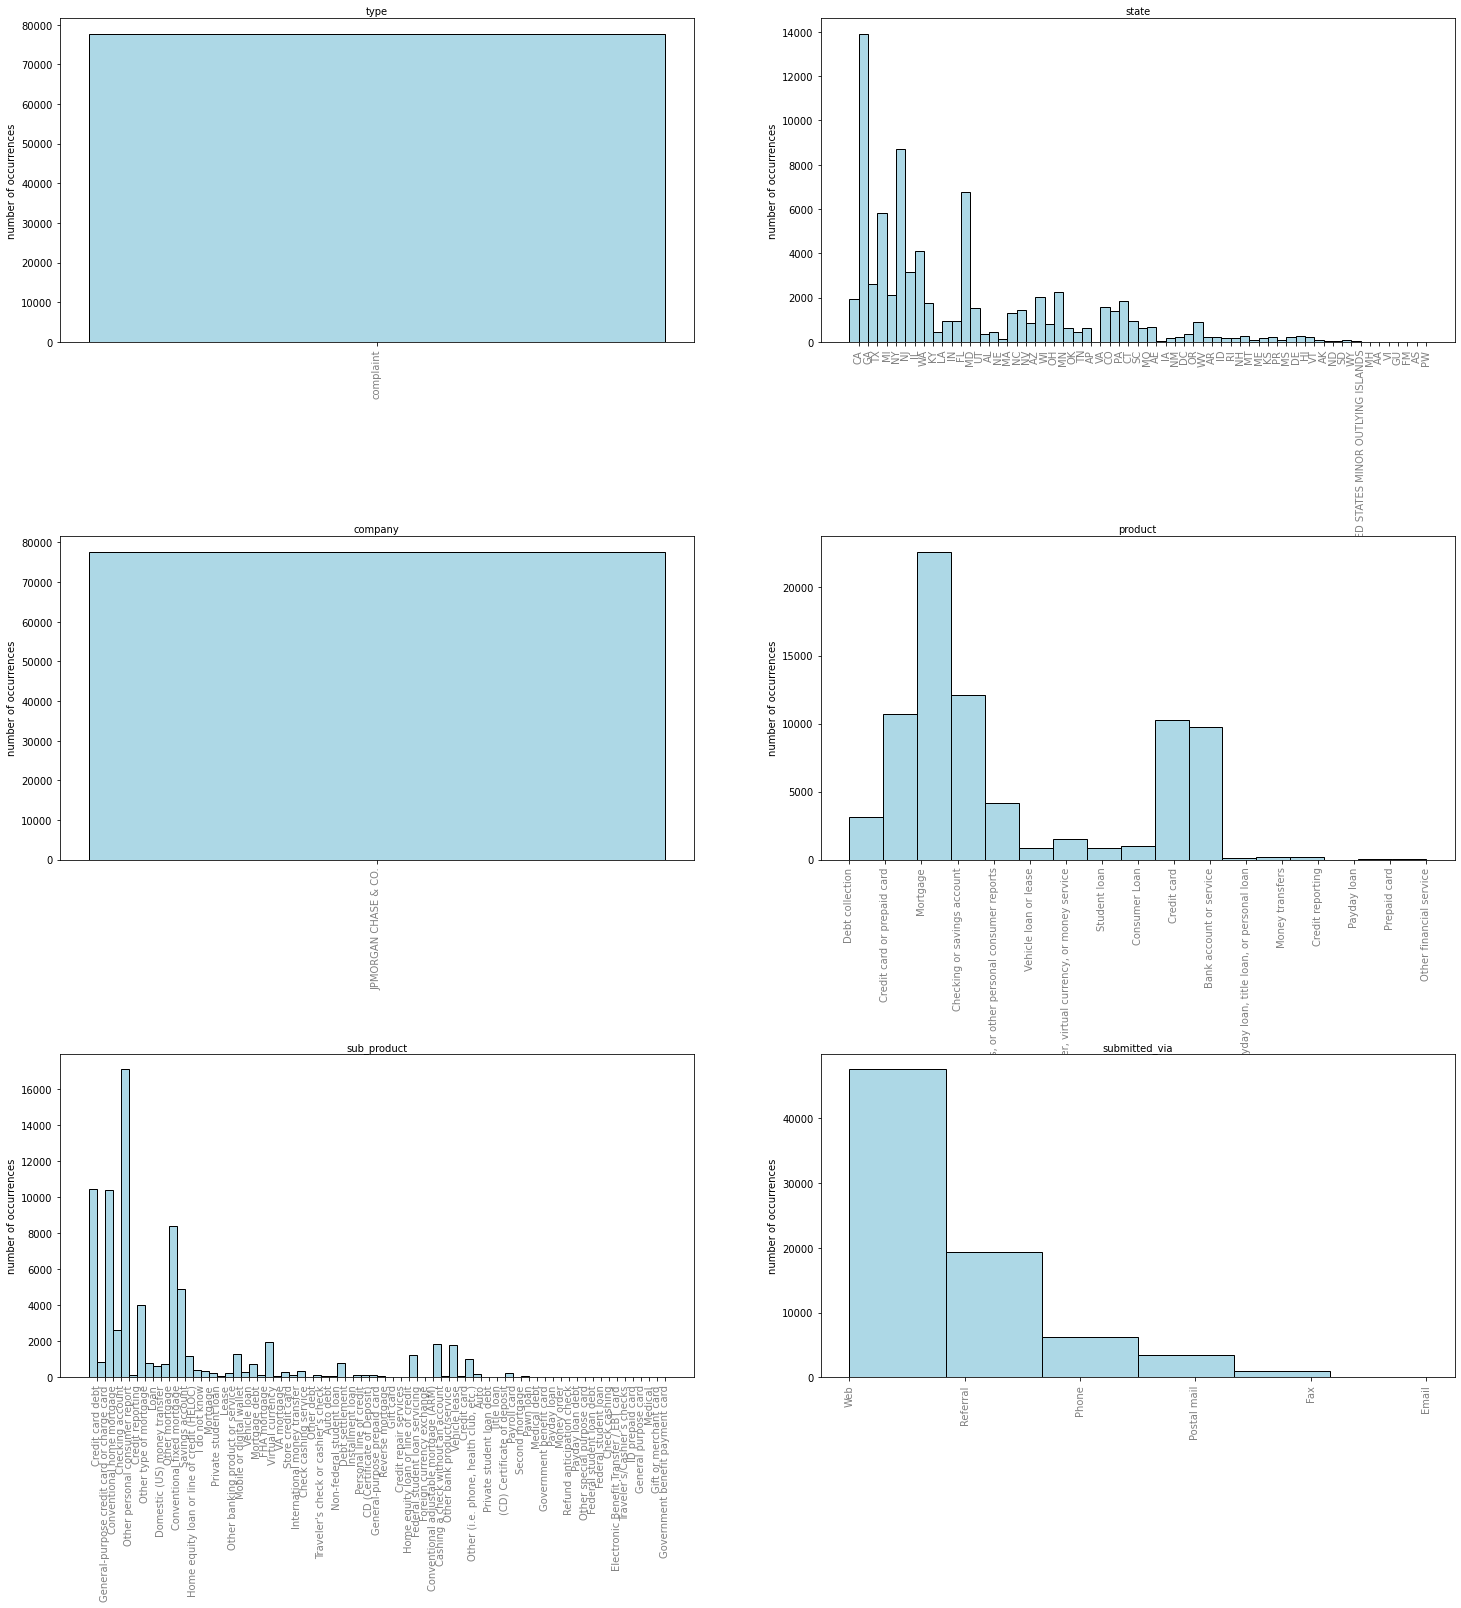

In [ ]:
from IPython.core.pylabtools import figsize
def plot_categorical_values(df, cols):
  rows = int(len(cols)/2)
  fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(25, 25))
  fig.subplots_adjust(hspace = .6, wspace=.2)
  
  fact_cat = []
  for col in cols:
    factorized, categories = pd.factorize(df[col])
    fact_cat.append((factorized,categories, col))

  for cat, ax in zip(fact_cat, axes.flat):
    ax.hist(cat[0], bins=len(cat[1]), color='lightblue', ec="black")
    ax.set_xticks(range(len(cat[1])), cat[1], rotation='vertical', alpha=0.5)
    ax.set_xlabel(cat[2])
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('number of occurrences')
  plt.show()

plot_categorical_values(df, cols)
    

## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


Este proceso fue realizado en la sección de abajo

## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

In [ ]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from pprint import pprint


In [ ]:
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 50)

In [ ]:
from textblob import TextBlob

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
import pickle

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21009 entries, 1 to 78312
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype                                 
---  ------                           --------------  -----                                 
 0   index                            21009 non-null  category                              
 1   type                             21009 non-null  category                              
 2   score                            21009 non-null  float64                               
 3   zip_code                         16383 non-null  category                              
 4   issue                            21009 non-null  object                                
 5   date_received                    21009 non-null  datetime64[ns, pytz.FixedOffset(-300)]
 6   state                            20868 non-null  category                              
 7   consumer_disputed                21009 non-null  

In [ ]:
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [ ]:
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,score,zip_code,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,consumer_conset_provided,complaint_what_happened_process


In [ ]:
df.shape

(21009, 18)

In [ ]:
df = df[~df['complaint_what_happened'].isnull()]

In [ ]:
df.shape

(21009, 18)

In [ ]:
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [ ]:
def clean_text(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent) 
    pattern = '\w*\d\w*' # Removing words with numbers in between
    sent = re.sub(pattern, '', sent) 
    return sent

In [ ]:
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [ ]:
df_clean

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [ ]:
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [ ]:
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize_text)

In [ ]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...


In [ ]:
def get_POS_tags(text):
    sent = []
    blob = TextBlob(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sent)

In [ ]:
df_clean['complaint_POS_removed'] = df_clean['complaint_lemmatized'].apply(get_POS_tags)

In [ ]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...


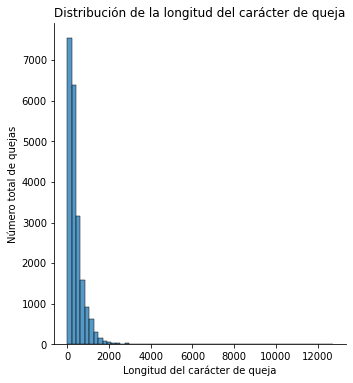

In [ ]:
# visualizamos los datos de acuerdo con la longitud del carácter 'Queja'
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Longitud del carácter de queja")
plt.ylabel("Número total de quejas")
plt.title("Distribución de la longitud del carácter de queja")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

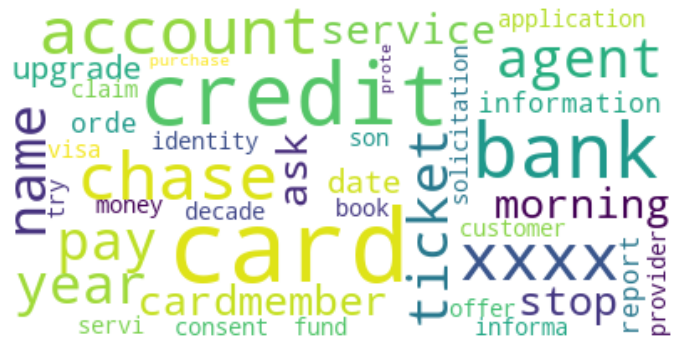

In [ ]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
#Removiendo los pron del cuerpo del texto
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
# Creación para poder extraer los mejores n-gramas (unigramas, bigramas, trigramas) en función de las entradas de la mismna
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [ ]:
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,xxxx,223534
1,xx,76844
2,tell,19651
3,receive,17733
4,chase,17518
5,pay,15968
6,say,14034
7,send,13094
8,ask,10967
9,bank,10695


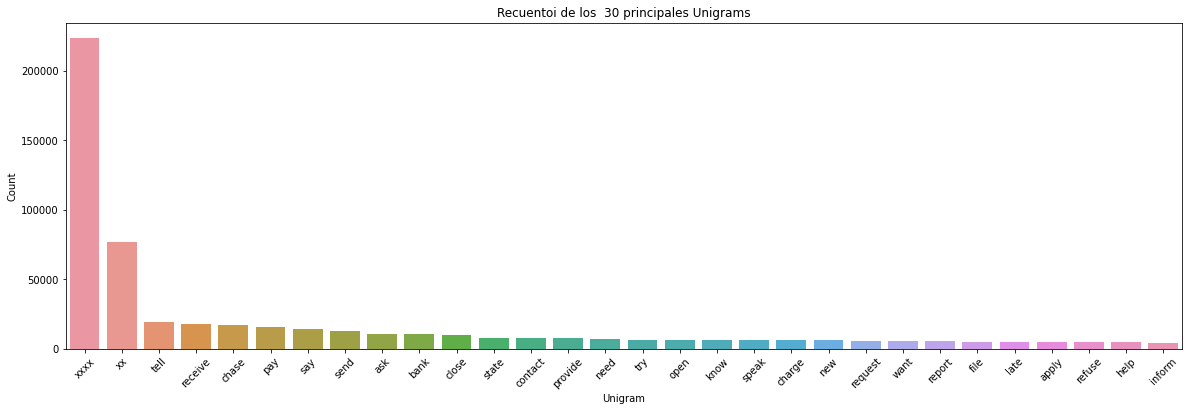

In [ ]:
# traazado de los 30 mejores unigramas
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Recuentoi de los  30 principales Unigrams")
plt.show()

In [ ]:
##mostrando las 10 palabras principales en la frecuencia del unigrama
df_unigram.head(10)

,unigram,count
0,xxxx,223534
1,xx,76844
2,tell,19651
3,receive,17733
4,chase,17518
5,pay,15968
6,say,14034
7,send,13094
8,ask,10967
9,bank,10695


In [ ]:
# encuentra la frecuencia de los 30 unigramas principales entre las quejas en el marco de datos limpio (df_clean).
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,xxxx xxxx,98988
1,xx xx,38677
2,xx xxxx,29728
3,chase bank,8249
4,xxxx xx,8123
5,xxxx receive,3446
6,xxxx chase,3023
7,xxxx tell,2835
8,jp morgan,2695
9,receive xxxx,2406


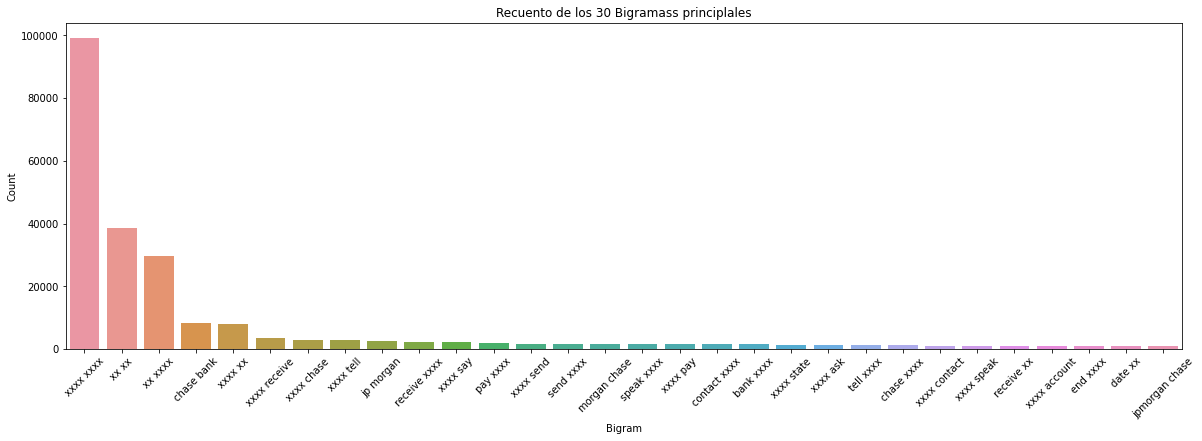

In [ ]:
# Trazamos los  meojeres bimgramas en un  rango de 30
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Recuento de los 30 Bigramass principlales")
plt.show()

In [ ]:
#imprimimos las 10  principales palabras en la frecuencia del bigrama
df_bigram.head(10)

,bigram,count
0,xxxx xxxx,98988
1,xx xx,38677
2,xx xxxx,29728
3,chase bank,8249
4,xxxx xx,8123
5,xxxx receive,3446
6,xxxx chase,3023
7,xxxx tell,2835
8,jp morgan,2695
9,receive xxxx,2406


In [ ]:
#Enciontramos la frecuencia de los 30  principales trigramas entre las quejas en el marco de datos limpios del (df_clean).
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,xxxx xxxx xxxx,50459
1,xx xx xxxx,29287
2,xxxx xx xx,8096
3,xx xxxx xxxx,4737
4,xx xxxx xx,3391
5,xxxx xxxx xx,2488
6,jp morgan chase,1580
7,xx xxxx receive,1466
8,xxxx xxxx chase,1174
9,xx xx xx,1169


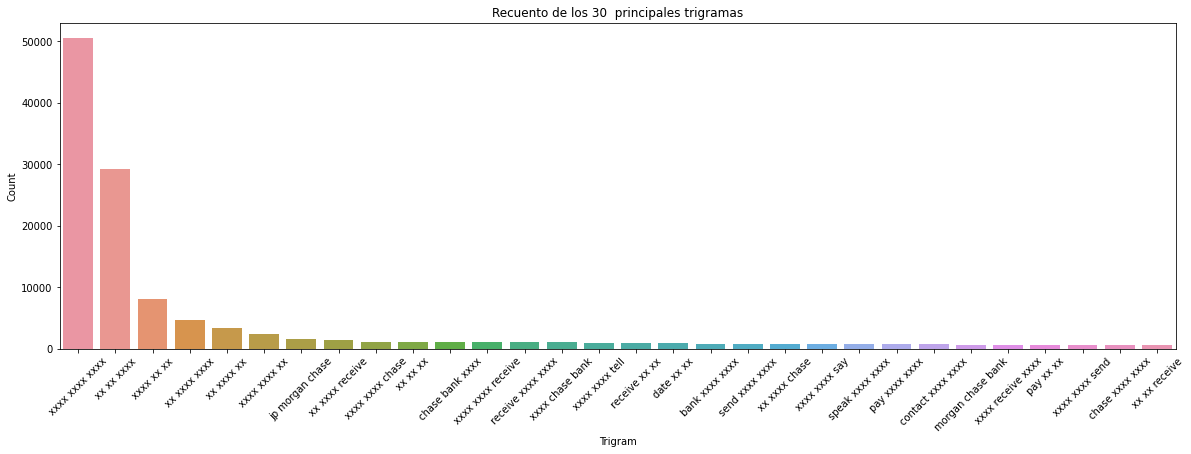

In [ ]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Recuento de los 30  principales trigramas")
plt.show()

In [ ]:
#Mostramos las 10  principalespalabras  en la frecuencia del trigrama
df_trigram.head(10)

,trigram,count
0,xxxx xxxx xxxx,50459
1,xx xx xxxx,29287
2,xxxx xx xx,8096
3,xx xxxx xxxx,4737
4,xx xxxx xx,3391
5,xxxx xxxx xx,2488
6,jp morgan chase,1580
7,xx xxxx receive,1466
8,xxxx xxxx chase,1174
9,xx xx xx,1169


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('x{2,}','').replace('',np.nan,regex = True)
df_clean = df_clean.dropna()

In [ ]:
#Todos los textos enmascarados son eliminados.
df_clean

,RAW,RAW_basic_process,Lemma,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,good xxxx xxxx appreciate help chase bank card...,good appreciate help chase bank cardmember s...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xx xx and wa...,upgrade xxxx xxxx card xx xx tell agent upgrad...,upgrade xxxx xxxx card xx xx tell upgrade chan...,upgrade card xx xx tell upgrade change turn ...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xx xx however f...,chase card report xx xx fraudulent application...,report xx xx fraudulent submit fraudulently ob...,report xx xx fraudulent submit fraudulently ob...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while trying to book a xxxx xxxx ...,xx xx try book xxxx xxxx ticket come offer app...,xx xx try book xxxx xxxx come apply apply noti...,xx xx try book come apply apply notify immed...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it ...,grand son check deposit chase account fund cle...,grand deposit clear close pay say need speek g...,grand deposit clear close pay say need speek g...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,offer multiple acquire new approve new annual ...,offer multiple acquire new approve new annual ...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx i called chas my xxx...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,wednesday xx xx call chas visa ask xx xx p...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,familiar xxxx understand great provide believe...,familiar understand great provide believe saf...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs i ve had...,flawless credit yrs ve chase credit card chase...,flawless yrs ve chase specifically xxxx ve rec...,flawless yrs ve chase specifically ve recentl...


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# inicializamos el TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Se crea la matriz de términos del documento transformando la columna de quejas presente en df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [ ]:
dtm

<21003x7447 sparse matrix of type '<class 'numpy.float64'>'
	with 669033 stored elements in Compressed Sparse Row format>

# Other Cleaning
Este proceso fue ejecutado offline debido al uso de GPU, el resultado es "complaints_cleaned.xlsx"

In [ ]:
# Minúsculas todos los textos
df["complaint_what_happened_process"] = df["complaint_what_happened"].str.lower().replace('',np.nan,regex = True)

In [ ]:
# Eliminar fila de nulos
df = df.dropna(subset=['complaint_what_happened_process'])

In [ ]:
# Remover texto dentro []
df["complaint_what_happened_process"] = df["complaint_what_happened_process"].str.replace(r'\[.*?\]', ' ')
# Remover texto dentro {}
df["complaint_what_happened_process"] = df["complaint_what_happened_process"].str.replace(r'\{.*?\}', ' ')
# Remover puntuación
df["complaint_what_happened_process"] = df["complaint_what_happened_process"].str.replace('[{}]'.format(string.punctuation), ' ')
# Remover números
df["complaint_what_happened_process"] = df["complaint_what_happened_process"].str.replace(r'\w*\d\w*', ' ')

In [ ]:
# Obtener lista
complaints = df["complaint_what_happened_process"].values.tolist()

In [ ]:
# Obtener tokens, lemma, sin NN, esta etapa puede demorar demasiado tiempo al procesarse (NLP de todo el dataset para complaints usando spaCy)

def pre_process_complaints(complaints: list):
  complaints_lemma = []
  complaints_lemma_no_nn = []
  tokens = []

  for doc in nlp.pipe(complaints, batch_size=128):
      tokens_doc = []
      complaints_lemma_doc = []
      complaints_lemma_no_nn_doc = []
      for token in doc:
          if not token.is_stop and token.is_alpha:
              tokens_doc.append(token)
              complaints_lemma_doc.append(token.lemma_)
              if token.pos_ != 'NOUN':
                  complaints_lemma_no_nn_doc.append(token.lemma_)
      
      tokens.append(tokens_doc)
      lemma_sentence     = " ".join(complaints_lemma_doc)
      no_nn_lemma_sentence = " ".join(complaints_lemma_no_nn_doc)
      complaints_lemma.append(lemma_sentence)
      complaints_lemma_no_nn.append(no_nn_lemma_sentence)
  return complaints_lemma, complaints_lemma_no_nn, tokens

In [ ]:
complaints_lemma, complaints_lemma_no_nn, tokens = pre_process_complaints(complaints)

In [ ]:
df_clean = pd.DataFrame({
    "RAW": df["complaint_what_happened"], 
    "RAW_basic_process": complaints, 
    "Lemma": complaints_lemma, 
    "complaint_POS_removed": complaints_lemma_no_nn
})

In [ ]:
df_clean["Complaint_clean"] = df_clean["complaint_POS_removed"].str.replace('-PRON-', '').str.replace('x{2,}','').replace('',np.nan,regex = True)
df_clean = df_clean.dropna()

# Topic Modeling using BERTopic
BERTopic es un modelo para obtener tópicos de forma no supervisada, este cuenta con un estimador de cantidad de tópicos utilizando HDBSCAN y variadas facilidades de visualización, además, el mismo utiliza BERT para obtener los embeddings, este método permite la sobreposición de clusters, por tal razón si se revisa las palabras por cada tópico se verá que se repiten

In [ ]:
# Se instancia el modelo
model = BERTopic(verbose=True, nr_topics=5)
docs  = df_clean["Complaint_clean"].values.tolist()
topics, probabilities = model.fit_transform(docs)

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

2023-02-24 13:00:53,319 - BERTopic - Transformed documents to Embeddings
2023-02-24 13:01:46,127 - BERTopic - Reduced dimensionality
2023-02-24 13:01:53,291 - BERTopic - Clustered reduced embeddings
2023-02-24 13:01:57,200 - BERTopic - Reduced number of topics from 16 to 5


In [ ]:
model.get_topic_freq()

,Topic,Count
0,0,20685
1,1,199
2,-1,51
3,2,43
4,3,25


In [ ]:
model.visualize_barchart()

In [ ]:
model.visualize_heatmap()

In [ ]:
model.visualize_hierarchy()

In [ ]:
model.get_topic(-1)

[('jpmcb', 0.19463906468053946),
 ('late', 0.12481673098804279),
 ('thank', 0.09894642876155406),
 ('corona', 0.07465518687729247),
 ('find', 0.07167500791563082),
 ('notice', 0.0701919297412605),
 ('pandemic', 0.06705633171497236),
 ('report', 0.06659378351593713),
 ('deduct', 0.06575666981457506),
 ('fast', 0.06565669787544624)]

Otros

In [ ]:
model.get_topic(0)

[('tell', 0.047539643312214955),
 ('receive', 0.04430946489026894),
 ('chase', 0.04426236619884813),
 ('pay', 0.04166055529409023),
 ('call', 0.040007209032480756),
 ('say', 0.038283520580946945),
 ('send', 0.03651695759765539),
 ('ask', 0.03247950712142085),
 ('bank', 0.031967311088006725),
 ('close', 0.03031672813542291)]

Prestamos Hipotecarios y Otros Prestamos

In [ ]:
model.get_topic(1)

[('amazon', 0.2891186788791284),
 ('receive', 0.0604494675040318),
 ('prime', 0.0519562615907664),
 ('call', 0.044097734554727215),
 ('chase', 0.04380562541893637),
 ('tell', 0.04257386598434402),
 ('send', 0.040671164276025164),
 ('pay', 0.03981279589751061),
 ('say', 0.038123747726695134),
 ('visa', 0.03620333014258903)]

Tarjetas de Credito / Tarjetas Prepagadas

In [ ]:
model.get_topic(2)

[('usc', 0.27448025427511175),
 ('aforesaid', 0.16332844791192747),
 ('tune', 0.16221874449258314),
 ('unfavorable', 0.15674320405239928),
 ('report', 0.15325286187014883),
 ('complete', 0.15017603010550878),
 ('lately', 0.14876023038351746),
 ('desist', 0.14857566606195274),
 ('confirm', 0.1363337043082975),
 ('accurate', 0.12300341719491485)]

Servicios de Cuentas de Banco

In [ ]:
model.get_topic(3)

[('incorrect', 0.831832694195761),
 ('file', 0.6893865531099346),
 ('receive', 0.417985952131537),
 ('not', 0.4159606900446116),
 ('haven', 0.3424927916450024),
 ('monthly', 0.13410586954049084),
 ('misfile', 0.08048953153876703),
 ('despite', 0.07483339534969836),
 ('paste', 0.06356753922780328),
 ('ve', 0.06151722173015556)]

Reportes de Robos

In [ ]:
model.visualize_topics()

Considerando:
* -1 = Otros
* 0  = Prestamos Hipotecarios y Otros Prestamos
* 1  = Tarjetas de Credito / Tarjetas Prepagadas
* 2  = Servicios de Cuentas de Banco
* 3  = Reportes de Robos

In [ ]:
model.get_topic_freq()

,Topic,Count
0,0,20685
1,1,199
2,-1,51
3,2,43
4,3,25


## Usando el dataset RAW

In [ ]:
model = BERTopic(verbose=True)
docs = df_clean["RAW"].values.tolist()
topics, probabilities = model.fit_transform(docs)
model.visualize_topics()

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

2023-02-24 14:08:50,385 - BERTopic - Transformed documents to Embeddings
2023-02-24 14:09:16,907 - BERTopic - Reduced dimensionality
2023-02-24 14:09:20,885 - BERTopic - Clustered reduced embeddings


Se puede evidenciar bastante sobreposición de los clusters, siendo un total de 132, este cluster no puede ser analizado con facilidad y da a entender que el número de clusters debería ser menor

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

Se re-utiliza el código definido más arriba para tfidf pero con el nuevo dataset limpiado con spaCy

In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.95, min_df = 2 )
tfidf_matrix = vectorizer.fit_transform(df_clean["Complaint_clean"])

In [ ]:
# NMF con 4 tópicos
nmf = NMF(n_components=4, random_state=40)

# Entrenar
nmf.fit(tfidf_matrix)

# Top 10 de palabras por tópico 
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()

Topic 0:
tell, receive, say, send, ask, contact, state, speak, provide, need

Topic 1:
pay, late, charge, report, remove, owe, monthly, continue, past, want

Topic 2:
chase, bank, morgan, jp, report, fraudulent, refuse, remove, jpmorgan, provide

Topic 3:
close, open, new, tell, deposit, direct, account, check, personal, closed



Se considera que con n = 4 no es ideal el clustering ya que no tendrá la precisión esperada considerando la multitud de tópicos que se pueden tener, ya que se tienen 5 clases que se quieren identificar

In [ ]:
# NMF con 5 tópicos
nmf = NMF(n_components=5, random_state=57)

# Entrenar
nmf.fit(tfidf_matrix)

# Top 10 de palabras por tópico 
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()

Topic 0:
tell, receive, say, send, ask, contact, state, speak, provide, need

Topic 1:
pay, charge, owe, monthly, want, high, annual, agree, minimum, total

Topic 2:
bank, chase, morgan, jp, refuse, jpmorgan, fraudulent, provide, file, write

Topic 3:
close, open, new, tell, deposit, direct, account, check, personal, closed

Topic 4:
late, report, remove, jpmcb, fraudulent, dispute, hard, correct, negative, past



Con ello se considera tener:

Topic 0: Otros

Topic 1: Tarjeta de crédito

Topic 2: Prestamos Hipotecarios y Otros Prestamos

Topic 3: Servicio de cuenta de banco

Topic 4: Reporte de robos

In [ ]:
topics = nmf.transform(vectorizer.transform(df_clean["Complaint_clean"]))
predicted_labels = np.argmax(topics, axis=1)
df_clean['Topic'] = predicted_labels

In [ ]:
df_clean.head()

,RAW,RAW_basic_process,Lemma,complaint_POS_removed,Complaint_clean,Topic,Topic_literal
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,good xxxx xxxx appreciate help chase bank card...,good appreciate help chase bank cardmember s...,2,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xx xx and wa...,upgrade xxxx xxxx card xx xx tell agent upgrad...,upgrade xxxx xxxx card xx xx tell upgrade chan...,upgrade card tell upgrade change turn give...,0,Others
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xx xx however f...,chase card report xx xx fraudulent application...,report xx xx fraudulent submit fraudulently ob...,report fraudulent submit fraudulently obtain...,4,Mortgage/Loan
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while trying to book a xxxx xxxx ...,xx xx try book xxxx xxxx ticket come offer app...,xx xx try book xxxx xxxx come apply apply noti...,try book come apply apply notify immediate...,0,Others
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposi...,grand son check deposit chase account fund cle...,grand deposit clear close pay say need speek g...,grand deposit clear close pay say need speek g...,1,Theft/Dispute Reporting


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean_head = df_clean.groupby('Topic').head(5)
print(df_clean_head.sort_values('Topic')[["RAW", "Topic"]].values)

[['I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.'
  0]
 ['On XX/XX/2018, while trying to book a XXXX  XXXX  ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX  offer

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

A base de las palabras anteriores y la evaluación actual:

* Topic 0: Otros (Others)
* Topic 1: Reporte de robos (Theft/Dispute Reporting)
* Topic 2: Servicio de cuenta de banco (Bank Account services)
* Topic 3: Tarjeta de crédito (Credit card or prepaid card)
* Topic 4: Prestamos Hipotecarios y Otros Prestamos (Mortgage/Loan)

In [ ]:
#Create the dictionary of Topic names and Topics
Topic_names = {0: "Others", 1: "Theft/Dispute Reporting", 2: "Bank Account services", 3: "Credit card or prepaid card", 4: "Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic_literal'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,RAW,RAW_basic_process,Lemma,complaint_POS_removed,Complaint_clean,Topic,Topic_literal
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,good xxxx xxxx appreciate help chase bank card...,good appreciate help chase bank cardmember s...,2,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xx xx and wa...,upgrade xxxx xxxx card xx xx tell agent upgrad...,upgrade xxxx xxxx card xx xx tell upgrade chan...,upgrade card tell upgrade change turn give...,0,Others
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xx xx however f...,chase card report xx xx fraudulent application...,report xx xx fraudulent submit fraudulently ob...,report fraudulent submit fraudulently obtain...,4,Mortgage/Loan
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while trying to book a xxxx xxxx ...,xx xx try book xxxx xxxx ticket come offer app...,xx xx try book xxxx xxxx come apply apply noti...,try book come apply apply notify immediate...,0,Others
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposi...,grand son check deposit chase account fund cle...,grand deposit clear close pay say need speek g...,grand deposit clear close pay say need speek g...,1,Theft/Dispute Reporting
...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,offer multiple acquire new approve new annual ...,offer multiple acquire new approve new annual ...,1,Theft/Dispute Reporting
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xx xx xxxx i called chas my xxx...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,wednesday xx xx xxxx call chas xxxx xxxx visa ...,wednesday call chas visa ask purchase ...,0,Others
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,familiar xxxx understand great provide believe...,familiar understand great provide believe saf...,0,Others
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs i ve had...,flawless credit yrs ve chase credit card chase...,flawless yrs ve chase specifically xxxx ve rec...,flawless yrs ve chase specifically ve recentl...,1,Theft/Dispute Reporting


#Model building using Supervised Learning

In [ ]:
# Eliminar valores nulos
df_clean.dropna(inplace=True)

In [ ]:
# Preparar los datos de Train, Test y Validation
X = df_clean["Complaint_clean"]
y = df_clean["Topic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Vectorizar los datos
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

La creación y aplicación del vectorizador TF-IDF en el código se realiza con el fin de convertir las quejas en texto en vectores numéricos, que puedan ser utilizados por los modelos de aprendizaje automático.

TF-IDF es una técnica de ponderación de términos que asigna un peso a cada término en un documento en función de su frecuencia en el documento y su frecuencia inversa en el corpus. La idea es dar más peso a los términos que son importantes en un documento pero poco frecuentes en el corpus, mientras que se les da menos peso a los términos que son comunes en el corpus pero no aportan mucha información sobre el contenido del documento.

In [ ]:
# Crear modelos
lr = LogisticRegression(max_iter=250)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = MultinomialNB()

***Regresión logística:*** es un modelo lineal que utiliza una función sigmoide para mapear la entrada a una probabilidad de pertenencia a una clase. El modelo de regresión logística se entrena utilizando la función de pérdida logarítmica y el método de descenso de gradiente. Se utiliza el parámetro max_iter para especificar el número máximo de iteraciones permitidas para la convergencia.

***Árbol de decisión:*** es un modelo no lineal que divide el espacio de entrada en regiones utilizando un conjunto de reglas de decisión basadas en las características de la entrada. El modelo de árbol de decisión se entrena utilizando un algoritmo que busca la mejor forma de dividir el espacio de entrada en regiones más homogéneas.

***Bosque aleatorio:*** es un modelo que combina varios árboles de decisión para mejorar la precisión y reducir el sobreajuste. El modelo de bosque aleatorio se entrena utilizando un conjunto de árboles de decisión y un método de muestreo aleatorio para seleccionar las características y las instancias utilizadas en cada árbol.

***Naive Bayes:*** es un modelo probabilístico que utiliza el teorema de Bayes para calcular la probabilidad de pertenencia a una clase dada una entrada. El modelo de Naive Bayes se entrena utilizando la suposición de independencia condicional entre las características de la entrada.

#Model training and evaluation

In [ ]:
# Entrenar modelos
lr.fit(X_train_tfidf, y_train)
dt.fit(X_train_tfidf, y_train)
rf.fit(X_train_tfidf, y_train)
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
# Evaluar modelos
models = [lr, dt, rf, nb]
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes"]
train_scores = []
val_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model in models:
    train_scores.append(cross_val_score(model, X_train_tfidf, y_train, cv=5).mean())
    val_scores.append(model.score(X_val_tfidf, y_val))
    y_val_pred = model.predict(X_val_tfidf)
    accuracy_scores.append(accuracy_score(y_val, y_val_pred))
    precision_scores.append(precision_score(y_val, y_val_pred, average="weighted"))
    recall_scores.append(recall_score(y_val, y_val_pred, average="weighted"))
    f1_scores.append(f1_score(y_val, y_val_pred, average="weighted"))

model_comparison = pd.DataFrame({
    "Model": model_names,
    "Training Score": train_scores,
    "Validation Score": val_scores,
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})


Las métricas de evaluación utilizadas son:

1. ***Precisión:*** es la proporción de instancias positivas que fueron clasificadas correctamente como positivas en comparación con el número total de instancias clasificadas como positivas (verdaderos positivos más falsos positivos). Se utiliza la función precision_score para calcular esta métrica. Esta función toma como entrada las etiquetas verdaderas y predichas y devuelve la precisión como un número entre 0 y 1. La precisión ponderada es la precisión promedio ponderada por el número de muestras en cada clase. Se utiliza el parámetro average="weighted" para calcular la precisión ponderada.

2. ***Recall:*** es la proporción de instancias positivas que fueron clasificadas correctamente como positivas en comparación con el número total de instancias positivas (verdaderos positivos más falsos negativos). Se utiliza la función recall_score para calcular esta métrica. Esta función toma como entrada las etiquetas verdaderas y predichas y devuelve el recall como un número entre 0 y 1. El recall ponderado es el recall promedio ponderado por el número de muestras en cada clase. Se utiliza el parámetro average="weighted" para calcular el recall ponderado.

3. ***F1 Score:*** es la media armónica de la precisión y el recall, y se utiliza para equilibrar ambos valores. Se utiliza la función f1_score para calcular esta métrica. Esta función toma como entrada las etiquetas verdaderas y predichas y devuelve el F1 Score como un número entre 0 y 1. El F1 Score ponderado es el F1 Score promedio ponderado por el número de muestras en cada clase. Se utiliza el parámetro average="weighted" para calcular el F1 Score ponderado.

4. ***Exactitud (Accuracy):*** es la proporción de instancias que fueron clasificadas correctamente. Se utiliza la función accuracy_score para calcular esta métrica. Esta función toma como entrada las etiquetas verdaderas y predichas y devuelve la exactitud como un número entre 0 y 1.

5. ***Matriz de Confusión:*** es una tabla que muestra el número de instancias que fueron clasificadas correctamente e incorrectamente por el modelo. Se utiliza la función confusion_matrix para calcular esta métrica. Esta función toma como entrada las etiquetas verdaderas y predichas y devuelve una matriz de confusión.

6. ***Reporte de Clasificación:*** es una tabla que muestra las puntuaciones de precisión, recall y F1 Score para cada clase. Se utiliza la función classification_report para calcular esta métrica. Esta función toma como entrada las etiquetas verdaderas y predichas y devuelve un reporte de clasificación.

In [ ]:
# Imprimir resultados de comparación de modelos
print(model_comparison)


                 Model  Training Score  Validation Score  Accuracy  Precision  \
0  Logistic Regression        0.914038          0.923155  0.923155   0.927456   
1        Decision Tree        0.768472          0.785107  0.785107   0.785255   
2        Random Forest        0.755378          0.766066  0.766066   0.812939   
3          Naive Bayes        0.458464          0.459028  0.459028   0.717521   

     Recall  F1 Score  
0  0.923155  0.923051  
1  0.785107  0.785108  
2  0.766066  0.759560  
3  0.459028  0.349921  


La tabla muestra los resultados de comparación de los cuatro modelos de aprendizaje automático entrenados en los datos de entrenamiento y validación.

La columna "Model" indica el nombre del modelo correspondiente.
La columna "Training Score" indica el puntaje promedio de validación cruzada de 5 pliegues para el modelo en los datos de entrenamiento.
La columna "Validation Score" indica el puntaje del modelo en los datos de validación.
Las columnas "Accuracy", "Precision", "Recall" y "F1 Score" son métricas de evaluación relevantes utilizadas para evaluar la capacidad de clasificación del modelo.
De acuerdo con los resultados de la tabla, se puede ver que el modelo de regresión logística es el mejor modelo, ya que obtuvo la puntuación más alta en las métricas de "Validation Score", "Accuracy", "Precision", "Recall" y "F1 Score". Los otros modelos obtuvieron puntuaciones más bajas en estas métricas, lo que sugiere que tienen un rendimiento inferior al modelo de regresión logística en el conjunto de datos de prueba.

La regresión logística tiene un alto puntaje de validación cruzada y de validación en los datos de entrenamiento y validación respectivamente, lo que sugiere que es un modelo estable y generaliza bien para datos nuevos. Por lo tanto, se puede elegir el modelo de regresión logística como el mejor modelo para clasificar las quejas en temas.

In [ ]:
# Obtener el mejor modelo
best_model_index = model_comparison["Validation Score"].idxmax()
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]
print(f"El mejor modelo es : {best_model_name}")


El mejor modelo es : Logistic Regression


In [ ]:
# Validar mejor modelo
best_model.fit(X_train_tfidf, y_train)
y_val_pred = best_model.predict(X_val_tfidf)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average="weighted")
recall = recall_score(y_val, y_val_pred, average="weighted")
f1 = f1_score(y_val, y_val_pred, average="weighted")
conf_matrix = confusion_matrix(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)


Se utilizan los datos de validación para evaluar el desempeño del modelo después del entrenamiento.

In [ ]:
# Imprimir resultados de la evaluación del mejor modelo
print(f"Best model: {best_model_name}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Best model: Logistic Regression
Accuracy: 0.92
Precision: 0.93
Recall: 0.92
F1 Score: 0.92


Confusion Matrix:
[[1137    7    9    0    3]
 [  40  399    6    2    0]
 [  56    6  495    4    3]
 [  36    5    5  344    0]
 [  29    7    7    1  340]]


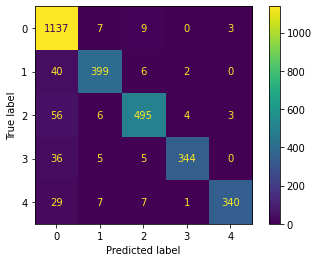

In [ ]:
print(f"Confusion Matrix:\n{conf_matrix}")
ConfusionMatrixDisplay(conf_matrix, display_labels=best_model.classes_).plot()

In [ ]:
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1156
           1       0.94      0.89      0.92       447
           2       0.95      0.88      0.91       564
           3       0.98      0.88      0.93       390
           4       0.98      0.89      0.93       384

    accuracy                           0.92      2941
   macro avg       0.95      0.90      0.92      2941
weighted avg       0.93      0.92      0.92      2941



El modelo obtuvo un Accuracy de 0.92, lo que significa que el 92% de las quejas fueron clasificadas correctamente.

El valor de Precision de 0.93 indica que cuando el modelo clasifica una queja como perteneciente a un tema en particular, el 93% de las veces esta clasificación es correcta.

El valor de Recall de 0.92 indica que el 92% de las quejas pertenecientes a un tema en particular fueron identificadas correctamente por el modelo.

El valor de F1 Score de 0.92 indica que el modelo tiene un buen equilibrio entre Precision y Recall.

La matriz de confusión (Confusion Matrix) muestra que la mayoría de las quejas son clasificadas correctamente por el modelo, y que los errores de clasificación se concentran principalmente en los temas 1 y 2.

El reporte de clasificación (Classification Report) proporciona una visión detallada de las métricas de evaluación para cada tema, incluyendo la precisión, recall y F1-score. Los valores más altos de estas métricas se observan en los temas 0, 1 y 2, mientras que los valores más bajos se observan en los temas 3 y 4.

Por los resultados se puede concluir que el modelo tiene un buen desempeño en la clasificación de las quejas, con un alto porcentaje de casos clasificados correctamente, un buen equilibrio entre Precision y Recall, y un bajo número de errores de clasificación.

#Model inference

In [ ]:
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar caracteres de puntuación
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Eliminar números
    text = re.sub(r'\d+', ' ', text)
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Lematización
    lemmatizer = WordNetLemmatizer()
    stemmed_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    # Unir tokens
    text = " ".join(stemmed_tokens)
    
    # Extraer partes del discurso (POS)
    pos_tags = nltk.pos_tag(word_tokenize(text))
    pos_tokens = [tag[0] for tag in pos_tags if tag[1].startswith('N') or tag[1].startswith('V')]
    text = " ".join(pos_tokens)
    
    return text


La función preprocess_text es utilizada para preprocesar un texto personalizado de manera que se pueda aplicar el modelo de clasificación a dicho texto. Esta función realiza las siguientes tareas de preprocesamiento:

1. Convierte todo el texto en minúsculas.
2. Elimina caracteres de puntuación.
3. Elimina números.
4. Tokeniza el texto.
5. Elimina palabras de parada (stopwords).
6. Lematiza las palabras.
7. Extrae las partes del discurso (POS) que sean sustantivos o verbos.
8. Une los tokens.

In [ ]:
def predict_topic_custom(text):
    # Preprocesar el texto personalizado
    processed_text = preprocess_text(text)
    
    # Vectorizar el texto preprocesado
    text_tfidf = tfidf_vectorizer.transform([processed_text])
    
    # Predecir el tema de la queja utilizando el mejor modelo encontrado previamente
    prediction = best_model.predict(text_tfidf)[0]
    
    return prediction

La función predict_topic_custom toma el texto preprocesado como entrada, vectoriza el texto utilizando el vectorizador tfidf_vectorizer que se ajustó previamente a los datos de entrenamiento, y luego utiliza el mejor modelo encontrado previamente para predecir el tema de la queja.

In [ ]:
map_topic = {
    0: 'Others',
    1: 'Theft/Dispute Reporting',
    2: 'Bank Account services',
    3: 'Credit card or prepaid card',
    4: 'Mortgage/Loan'
}

In [ ]:
text = "jp morgan chase bank  an individual or group of individuals have accessed sensitive information and are now calling in to document fake reports on my name and have blocked me out of my checking account  its a collective group of individuals doing a mass fraud scheme and have simply targeted me for whatever hateful and spiteful reasons."
prediction = predict_topic_custom(text)
print(f"The model predicts the complaint topic is {prediction} : {map_topic[prediction]}.")


The model predicts the complaint topic is 2 : Bank Account services.


Éste es el resultado de la predicción del modelo. Indica, tras preprocesar y analizar el texto, a que topico de queja pertenece. 

##Pruebas adicionales

In [ ]:
# leer el archivo csv y almacenar los datos en un dataframe
df_random_complaints = pd.read_csv('random_complaints.csv', sep='|')

def predict_and_print(df):
    # iterar sobre cada fila del dataframe
    for index, row in df.iterrows():
        # obtener la queja y el topico real
        complaint = row['complaint']
        actual_topic = row['topic']
        # obtener el topico predicho utilizando la función predict_topic_custom
        predicted_topic = predict_topic_custom(complaint)
        # imprimir la queja y los topics
        print(f"Complaint: {complaint}")
        print(f"Actual topic: {actual_topic}")
        print(f"Predicted topic: {map_topic[predicted_topic]}\n")

# llamar a la función con el dataframe df_random_complaints
predict_and_print(df_random_complaints)

Complaint: I am extremely disappointed with the level of customer service I received from your bank. I have been a loyal customer for years and I expected better treatment.
Actual topic: Others
Predicted topic: Bank Account services

Complaint: I noticed several unauthorized charges on my credit card statement and immediately reported them to your customer service team. However, the issue has yet to be resolved and I am extremely frustrated.
Actual topic: Theft/DisputeReporting
Predicted topic: Theft/Dispute Reporting

Complaint: I have been experiencing issues with my bank account for several months now. Transactions are not processing properly and I am not able to access my account online.
Actual topic: Bank Account services
Predicted topic: Bank Account services

Complaint: I am extremely unhappy with the interest rates on my credit card. Despite having a good credit score, I am being charged exorbitant fees and I believe this is unfair.
Actual topic: Credit card or prepaid card
Pre

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj